In [70]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input

# keras tuner for hyperparameter tuning
from keras_tuner import BayesianOptimization


In [6]:
def convert_to_float(val):
    """Converts a string to a float, replacing commas with dots.

    Args:
        val (str): The string to be converted to float.

    Returns:
        float: The float value of the string, or None if it can't be converted.
    """
    try:
        return float(val.replace('.', '').replace(',', '.'))
    except ValueError:
        return None

In [7]:
# Load the uploaded data files
production_df = pd.read_csv(r'C:\Repositories\electricity_lstm\data\realised_creation_201501010000_202407010000_15_min.csv', delimiter=';')
consumption_df = pd.read_csv(r'C:\Repositories\electricity_lstm\data\realised_consumption_201501010000_202407010000_15_min.csv', delimiter=';')


In [8]:
# Check the first few rows of the dataframes
consumption_df.columns

Index(['Datum von', 'Datum bis', 'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')

In [9]:
# Check the columns of the production data
production_df.columns

Index(['Datum von', 'Datum bis', 'Biomasse [MWh] Originalauflösungen',
       'Wasserkraft [MWh] Originalauflösungen',
       'Wind Offshore [MWh] Originalauflösungen',
       'Wind Onshore [MWh] Originalauflösungen',
       'Photovoltaik [MWh] Originalauflösungen',
       'Sonstige Erneuerbare [MWh] Originalauflösungen',
       'Kernenergie [MWh] Originalauflösungen',
       'Braunkohle [MWh] Originalauflösungen',
       'Steinkohle [MWh] Originalauflösungen',
       'Erdgas [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen',
       'Sonstige Konventionelle [MWh] Originalauflösungen'],
      dtype='object')

In [10]:
#### Convert the columns to a more readable format
# Translate column names for production data
production_df.columns = ['start_time', 'end_time', 'biomass_mwh', 'hydropower_mwh', 'wind_offshore_mwh',
                        'wind_onshore_mwh', 'solar_mwh', 'other_renewables_mwh', 'nuclear_mwh',
                        'lignite_mwh', 'hard_coal_mwh', 'natural_gas_mwh', 'pumped_storage_mwh', 'other_conventional_mwh']

# Translate column names for consumption data
consumption_df.columns = ['start_time', 'end_time', 'total_load_mwh', 'residual_load_mwh', 'saved_pumped_storage_mwh']


In [11]:
production_df.head()

,start_time,end_time,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,solar_mwh,other_renewables_mwh,nuclear_mwh,lignite_mwh,hard_coal_mwh,natural_gas_mwh,pumped_storage_mwh,other_conventional_mwh
0,01.01.2015 00:00,01.01.2015 00:15,"1.005,50","288,25","130,00","2.028,25","0,00","33,25","2.685,50","3.964,75","805,50","317,25","391,00","1.235,00"
1,01.01.2015 00:15,01.01.2015 00:30,"1.007,00","287,75","129,25","2.023,00","0,00","33,25","2.646,25","3.950,75","833,00","316,25","373,25","1.213,75"
2,01.01.2015 00:30,01.01.2015 00:45,"1.006,50","292,75","128,50","2.040,25","0,00","33,25","2.660,75","3.912,25","806,25","313,50","426,50","1.218,50"
3,01.01.2015 00:45,01.01.2015 01:00,"1.005,25","289,50","128,75","2.036,50","0,00","33,25","2.718,00","3.859,50","775,00","279,25","335,00","1.242,00"
4,01.01.2015 01:00,01.01.2015 01:15,"999,00","295,25","128,75","2.045,75","0,00","33,25","2.772,25","3.888,00","633,50","261,50","247,50","1.247,25"


In [12]:
# Convert numeric columns in production data
for col in production_df.columns[2:]:
    production_df[col] = production_df[col].apply(convert_to_float)

# Convert numeric columns in consumption data
for col in consumption_df.columns[2:]:
    consumption_df[col] = consumption_df[col].apply(convert_to_float)

In [13]:
#### Convert date and time columns to datetime format
# production data
production_df['start_time'] = pd.to_datetime(production_df['start_time'], format='%d.%m.%Y %H:%M')
production_df['end_time'] = pd.to_datetime(production_df['end_time'], format='%d.%m.%Y %H:%M')

# consumption data
consumption_df['start_time'] = pd.to_datetime(consumption_df['start_time'], format='%d.%m.%Y %H:%M')
consumption_df['end_time'] = pd.to_datetime(consumption_df['end_time'], format='%d.%m.%Y %H:%M')


In [14]:
production_df['end_time']

0        2015-01-01 00:15:00
1        2015-01-01 00:30:00
2        2015-01-01 00:45:00
3        2015-01-01 01:00:00
4        2015-01-01 01:15:00
                 ...        
333015   2024-06-30 23:00:00
333016   2024-06-30 23:15:00
333017   2024-06-30 23:30:00
333018   2024-06-30 23:45:00
333019   2024-07-01 00:00:00
Name: end_time, Length: 333020, dtype: datetime64[ns]

In [15]:
# merge the two dataframes
data = pd.merge(production_df, consumption_df, on=['start_time', 'end_time'])

In [16]:
data.head()

,start_time,end_time,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,solar_mwh,other_renewables_mwh,nuclear_mwh,lignite_mwh,hard_coal_mwh,natural_gas_mwh,pumped_storage_mwh,other_conventional_mwh,total_load_mwh,residual_load_mwh,saved_pumped_storage_mwh
0,2015-01-01 00:00:00,2015-01-01 00:15:00,1005.50,288.25,130.00,2028.25,0.0,33.25,2685.50,3964.75,805.50,317.25,391.00,1235.00,11210.00,9051.75,123.00
1,2015-01-01 00:15:00,2015-01-01 00:30:00,1007.00,287.75,129.25,2023.00,0.0,33.25,2646.25,3950.75,833.00,316.25,373.25,1213.75,11118.75,8966.50,154.25
2,2015-01-01 00:30:00,2015-01-01 00:45:00,1006.50,292.75,128.50,2040.25,0.0,33.25,2660.75,3912.25,806.25,313.50,426.50,1218.50,11144.75,8976.00,160.50
3,2015-01-01 00:45:00,2015-01-01 01:00:00,1005.25,289.50,128.75,2036.50,0.0,33.25,2718.00,3859.50,775.00,279.25,335.00,1242.00,11126.75,8961.50,163.75
4,2015-01-01 01:00:00,2015-01-01 01:15:00,999.00,295.25,128.75,2045.75,0.0,33.25,2772.25,3888.00,633.50,261.50,247.50,1247.25,11009.50,8835.00,87.50


In [17]:
# check if there is any NaN values in the data
data.isnull().sum()

start_time                      0
end_time                        0
biomass_mwh                     0
hydropower_mwh                  0
wind_offshore_mwh               0
wind_onshore_mwh                0
solar_mwh                       0
other_renewables_mwh            0
nuclear_mwh                 14634
lignite_mwh                     0
hard_coal_mwh                   0
natural_gas_mwh                 0
pumped_storage_mwh              0
other_conventional_mwh          1
total_load_mwh                  0
residual_load_mwh               3
saved_pumped_storage_mwh        0
dtype: int64

In [18]:
# replace the NaN values with 0
data.fillna(0, inplace=True)

In [19]:
data.isnull().sum()

start_time                  0
end_time                    0
biomass_mwh                 0
hydropower_mwh              0
wind_offshore_mwh           0
wind_onshore_mwh            0
solar_mwh                   0
other_renewables_mwh        0
nuclear_mwh                 0
lignite_mwh                 0
hard_coal_mwh               0
natural_gas_mwh             0
pumped_storage_mwh          0
other_conventional_mwh      0
total_load_mwh              0
residual_load_mwh           0
saved_pumped_storage_mwh    0
dtype: int64

In [20]:
data['total_production_mwh'] = data[['biomass_mwh', 'hydropower_mwh', 'wind_offshore_mwh', 'wind_onshore_mwh',
                                    'solar_mwh', 'other_renewables_mwh', 'nuclear_mwh', 'lignite_mwh', 'hard_coal_mwh',
                                    'natural_gas_mwh', 'pumped_storage_mwh', 'other_conventional_mwh']].sum(axis=1)


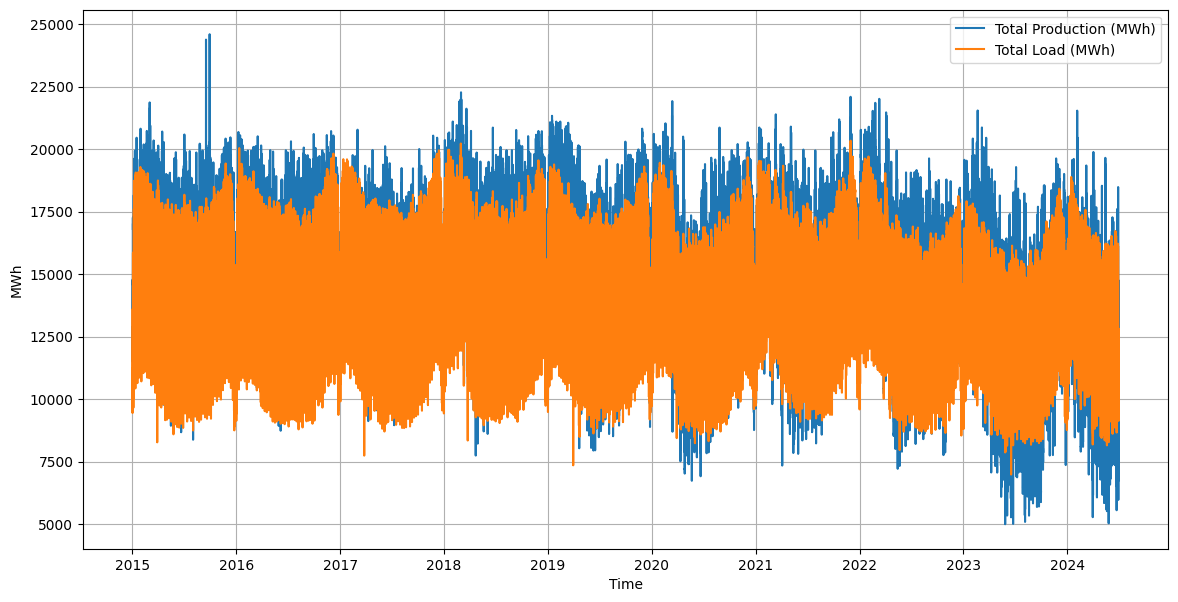

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(data['start_time'], data['total_production_mwh'], label='Total Production (MWh)')
plt.plot(data['start_time'], data['total_load_mwh'], label='Total Load (MWh)')
plt.xlabel('Time')
plt.ylabel('MWh')
# plt.title('Energy Production vs. Load')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# extract granular time information from the date_time in the data
data['hour'] = data["start_time"].dt.hour
data['minute'] = data["start_time"].dt.minute
data['day_of_week'] = data["start_time"].dt.dayofweek
data['day_of_year'] = data["start_time"].dt.dayofyear
data['week_of_year'] = data['start_time'].dt.isocalendar().week

In [23]:
data.head()

,start_time,end_time,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,solar_mwh,other_renewables_mwh,nuclear_mwh,lignite_mwh,...,other_conventional_mwh,total_load_mwh,residual_load_mwh,saved_pumped_storage_mwh,total_production_mwh,hour,minute,day_of_week,day_of_year,week_of_year
0,2015-01-01 00:00:00,2015-01-01 00:15:00,1005.50,288.25,130.00,2028.25,0.0,33.25,2685.50,3964.75,...,1235.00,11210.00,9051.75,123.00,12884.25,0,0,3,1,1
1,2015-01-01 00:15:00,2015-01-01 00:30:00,1007.00,287.75,129.25,2023.00,0.0,33.25,2646.25,3950.75,...,1213.75,11118.75,8966.50,154.25,12813.50,0,15,3,1,1
2,2015-01-01 00:30:00,2015-01-01 00:45:00,1006.50,292.75,128.50,2040.25,0.0,33.25,2660.75,3912.25,...,1218.50,11144.75,8976.00,160.50,12839.00,0,30,3,1,1
3,2015-01-01 00:45:00,2015-01-01 01:00:00,1005.25,289.50,128.75,2036.50,0.0,33.25,2718.00,3859.50,...,1242.00,11126.75,8961.50,163.75,12702.00,0,45,3,1,1
4,2015-01-01 01:00:00,2015-01-01 01:15:00,999.00,295.25,128.75,2045.75,0.0,33.25,2772.25,3888.00,...,1247.25,11009.50,8835.00,87.50,12552.00,1,0,3,1,1


In [24]:
# encode the date and time features in a way that captures the periodicity of the data
# include sine and cosine transformations for the hour and day of the week
def encode_feature(data, column_name:str, max_value:int):
    data[column_name + '_sin'] = np.sin(2 * np.pi * data[column_name] / max_value)
    data[column_name + '_cos'] = np.cos(2 * np.pi * data[column_name] / max_value)
    return data

In [25]:
# capture the cyclical nature of hours in a day.
encode_feature(data, 'hour', 24)
# capture the cyclical nature of minutes within each hour.
encode_feature(data, 'minute', 60)
# capture the cyclical nature of days within a week.
encode_feature (data, 'day_of_week', 7)
# capture the cyclical nature of days within a year.
encode_feature(data,'day_of_year', 365)
# capture the cyclical nature of weeks within a year.
encode_feature(data, 'week_of_year', 52)

,start_time,end_time,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,solar_mwh,other_renewables_mwh,nuclear_mwh,lignite_mwh,...,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos
0,2015-01-01 00:00:00,2015-01-01 00:15:00,1005.50,288.25,130.00,2028.25,0.0,33.25,2685.50,3964.75,...,0.000000,1.000000,0.000000e+00,1.000000e+00,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
1,2015-01-01 00:15:00,2015-01-01 00:30:00,1007.00,287.75,129.25,2023.00,0.0,33.25,2646.25,3950.75,...,0.000000,1.000000,1.000000e+00,2.832769e-16,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
2,2015-01-01 00:30:00,2015-01-01 00:45:00,1006.50,292.75,128.50,2040.25,0.0,33.25,2660.75,3912.25,...,0.000000,1.000000,5.665539e-16,-1.000000e+00,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
3,2015-01-01 00:45:00,2015-01-01 01:00:00,1005.25,289.50,128.75,2036.50,0.0,33.25,2718.00,3859.50,...,0.000000,1.000000,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
4,2015-01-01 01:00:00,2015-01-01 01:15:00,999.00,295.25,128.75,2045.75,0.0,33.25,2772.25,3888.00,...,0.258819,0.965926,0.000000e+00,1.000000e+00,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333087,2024-06-30 22:45:00,2024-06-30 23:00:00,1034.00,669.75,337.00,1400.00,0.0,28.00,0.00,2276.50,...,-0.500000,0.866025,-1.000000e+00,-1.836970e-16,-0.781831,0.623490,0.008607,-0.999963,-0.0,-1.0
333088,2024-06-30 23:00:00,2024-06-30 23:15:00,1036.25,643.00,342.25,1328.25,0.0,28.00,0.00,2290.50,...,-0.258819,0.965926,0.000000e+00,1.000000e+00,-0.781831,0.623490,0.008607,-0.999963,-0.0,-1.0
333089,2024-06-30 23:15:00,2024-06-30 23:30:00,1035.00,691.25,330.00,1283.75,0.0,28.00,0.00,2296.00,...,-0.258819,0.965926,1.000000e+00,2.832769e-16,-0.781831,0.623490,0.008607,-0.999963,-0.0,-1.0
333090,2024-06-30 23:30:00,2024-06-30 23:45:00,1035.50,652.00,292.50,1251.75,0.0,28.00,0.00,2289.00,...,-0.258819,0.965926,5.665539e-16,-1.000000e+00,-0.781831,0.623490,0.008607,-0.999963,-0.0,-1.0


In [26]:
# save the merged data
data.to_csv(r'C:\Repositories\electricity_lstm\data\cleaned_merged_data_with_15_min_interval.csv', index=False)

In [27]:
# Select relevant features for training
features = ['biomass_mwh', 'hydropower_mwh', 'wind_offshore_mwh',
            'wind_onshore_mwh', 'solar_mwh', 'other_renewables_mwh',
            'nuclear_mwh', 'lignite_mwh', 'hard_coal_mwh', 'natural_gas_mwh',
            'pumped_storage_mwh', 'other_conventional_mwh',
            'hour_sin', 'hour_cos',
            'minute_sin', 'minute_cos',
            'day_of_week_sin', 'day_of_week_cos',
            'day_of_year_sin', 'day_of_year_cos',
            'week_of_year_sin', 'week_of_year_cos']

# Output features
output_features = ['total_production_mwh', 'total_load_mwh']

# Combine into a complete list for dataframe alignment
all_columns = output_features + features

In [28]:
data[features].describe()

,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,solar_mwh,other_renewables_mwh,nuclear_mwh,lignite_mwh,hard_coal_mwh,natural_gas_mwh,...,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos
count,333092.000000,333092.000000,333092.000000,333092.000000,333092.000000,333092.000000,333092.000000,333092.000000,333092.000000,333092.000000,...,3.330920e+05,3.330920e+05,3.330920e+05,3.330920e+05,333092.000000,333092.000000,333092.000000,333092.000000,333092.0,333092.0
mean,1116.646363,431.996965,582.799680,2644.463319,1276.150307,39.340403,1638.330292,3065.933044,1650.175158,1165.157964,...,1.020739e-04,1.767972e-04,1.389462e-16,7.840561e-19,-0.000666,-0.000276,0.033087,0.000573,0.033328,0.001272
std,77.629309,100.958572,444.780204,2192.029381,2005.389301,10.557935,809.972459,970.231928,1073.384099,712.674083,...,7.070717e-01,7.071439e-01,7.071078e-01,7.071078e-01,0.707111,0.707104,0.706205,0.707236,0.705255,0.708171
min,849.250000,183.250000,0.000000,18.250000,0.000000,12.500000,0.000000,615.500000,83.250000,99.750000,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969,-0.999991,-0.999963,-1.0,-1.0
25%,1067.250000,354.500000,185.500000,962.250000,0.000000,31.750000,1017.750000,2464.000000,701.000000,594.250000,...,-7.071068e-01,-7.071068e-01,-2.500000e-01,-2.500000e-01,-0.781831,-0.900969,-0.674444,-0.708627,-0.663123,-0.748511
50%,1124.500000,424.750000,502.750000,1967.750000,22.750000,38.500000,1912.500000,3290.750000,1419.500000,1001.750000,...,1.224647e-16,6.123234e-17,2.832769e-16,4.978996e-17,0.000000,-0.222521,0.077386,0.004304,0.120537,-0.0
75%,1177.750000,501.250000,922.500000,3744.750000,1993.250000,47.250000,2254.000000,3819.500000,2465.250000,1624.250000,...,7.071068e-01,7.071068e-01,2.500000e-01,2.500000e-01,0.781831,0.623490,0.735417,0.702527,0.748511,0.748511
max,1293.250000,792.500000,1910.000000,12039.500000,12169.250000,65.000000,2868.500000,4956.750000,4816.750000,4169.250000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.974928,1.000000,0.999991,1.000000,1.0,1.0


In [29]:
# check the type of the features
data[features].dtypes

biomass_mwh               float64
hydropower_mwh            float64
wind_offshore_mwh         float64
wind_onshore_mwh          float64
solar_mwh                 float64
other_renewables_mwh      float64
nuclear_mwh               float64
lignite_mwh               float64
hard_coal_mwh             float64
natural_gas_mwh           float64
pumped_storage_mwh        float64
other_conventional_mwh    float64
hour_sin                  float64
hour_cos                  float64
minute_sin                float64
minute_cos                float64
day_of_week_sin           float64
day_of_week_cos           float64
day_of_year_sin           float64
day_of_year_cos           float64
week_of_year_sin          Float64
week_of_year_cos          Float64
dtype: object

In [44]:
# Split the data
train_data = data[data['start_time'] < '2015-03-01']  # '2022-01-01'
validation_data = data[(data['start_time'] >= '2022-01-01') & (data['start_time'] < '2023-01-01')]
test_data = data[data['start_time'] >= '2023-01-01']


In [45]:
train_data.head()

,start_time,end_time,biomass_mwh,hydropower_mwh,wind_offshore_mwh,wind_onshore_mwh,solar_mwh,other_renewables_mwh,nuclear_mwh,lignite_mwh,...,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos
0,2015-01-01 00:00:00,2015-01-01 00:15:00,1005.50,288.25,130.00,2028.25,0.0,33.25,2685.50,3964.75,...,0.000000,1.000000,0.000000e+00,1.000000e+00,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
1,2015-01-01 00:15:00,2015-01-01 00:30:00,1007.00,287.75,129.25,2023.00,0.0,33.25,2646.25,3950.75,...,0.000000,1.000000,1.000000e+00,2.832769e-16,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
2,2015-01-01 00:30:00,2015-01-01 00:45:00,1006.50,292.75,128.50,2040.25,0.0,33.25,2660.75,3912.25,...,0.000000,1.000000,5.665539e-16,-1.000000e+00,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
3,2015-01-01 00:45:00,2015-01-01 01:00:00,1005.25,289.50,128.75,2036.50,0.0,33.25,2718.00,3859.50,...,0.000000,1.000000,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709
4,2015-01-01 01:00:00,2015-01-01 01:15:00,999.00,295.25,128.75,2045.75,0.0,33.25,2772.25,3888.00,...,0.258819,0.965926,0.000000e+00,1.000000e+00,0.433884,-0.900969,0.017213,0.999852,0.120537,0.992709


In [46]:
# Scale the data
scaler = MinMaxScaler()
# fit the scaler on the training data
scaled_train_data = scaler.fit_transform(train_data[features])
# transform the validation and test data
scaled_validation_data = scaler.transform(validation_data[features])
scaled_test_data = scaler.transform(test_data[features])

In [47]:
def create_sequences(data, seq_length, pred_length, output_size):
    """Create sequences of input and output data for training the LSTM model.

    Args:
        data (array): The input data to be sequenced.
        seq_length (int): The length of the input sequences.
        pred_length (int): The length of the output sequences.
        output_size (int): The number of output features.

    Returns:
        _tuple_: A tuple of input and output sequences.
    """
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        # x is input sequence with the length of seq_length
        X.append(data[i:(i + seq_length)])
        # y is the output sequence with the length of pred_length
        y.append(data[(i + seq_length):(i + seq_length + pred_length), :output_size])
    return np.array(X), np.array(y)


In [48]:
# Example Usage
seq_length = 24*4 # 24 hours of 15-minute intervals
pred_length = 24*4  # Predict one day ahead
output_size = len(output_features)  # 2

X_train, y_train = create_sequences(scaled_train_data, seq_length, pred_length, output_size)
X_val, y_val = create_sequences(scaled_validation_data, seq_length, pred_length, output_size)
X_test, y_test = create_sequences(scaled_test_data, seq_length, pred_length, output_size)


In [49]:
y_train.shape
# (number of samples, pred_length, number of output features)

(5473, 96, 2)

In [50]:
X_train.shape
# ( number of samples, sequence length, number of input features)

(5473, 96, 22)

In [71]:

# build the naive LSTM model
def build_naive_lstm_model(input_shape, output_size, units=20, dropout=0.15):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    model.compile(optimizer='adam', loss='mse')
    return model

# build the stacked LSTM model
def build_stacked_lstm_model(input_shape, output_size, units=50, dropout=0.2, clip = True):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, activation='relu', return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(output_size))

    if clip:
        # Compile with gradient clipping
        optimizer = Adam(clipvalue=1.0)
        model.compile(optimizer=optimizer, loss='mse')
    else:
        model.compile(optimizer='adam', loss='mse')

    return model


In [56]:
y_train.shape

(5473, 96, 2)

In [57]:
y_train.reshape(y_train.shape[0], -1).shape

(5473, 192)

In [69]:

def optimize_seq_length(data, seq_lengths, pred_length, output_size, built_model,
                        epochs=10, batch_size=32, num_folds=3, verbose=2):
    """Optimize the sequence length for the LSTM model using KFold cross-validation.

    Args:
        data (dataframe): The input data to be sequenced.
        seq_lengths (list): A list of sequence lengths to try.
        pred_length (int): The length of the output sequences.
        output_size (int): The number of output features.
        built_model (function): The function to build the LSTM model.
        epochs (int, optional): Number of epochs to train the model. Defaults to 10.
        batch_size (int, optional): Batch size for training the model. Defaults to 32.
        num_folds (int, optional): Number of folds for cross-validation. Defaults to 3.

    Returns:
        _type_: _description_
    """
    # Use KFold cross-validation to find the best sequence length
    tscv = TimeSeriesSplit(n_splits=num_folds)
    # Initialize the best sequence length and loss
    best_seq_length = seq_lengths[0]
    # Set the best loss to infinity
    best_loss = float('inf')
    losses = []

    for seq_length in seq_lengths:
        total_loss = 0
        # store the loss for each fold
        fold_losses = []
        for train_index, val_index in tscv.split(data):
            # train and validation data for the current fold
            train_data, val_data = data[train_index], data[val_index]
            # Create sequences for the current fold for training and validation data
            X_train, y_train = create_sequences(train_data, seq_length, pred_length, output_size)
            X_val, y_val = create_sequences(val_data, seq_length, pred_length, output_size)

            # Build the model and train it on the training data
            model = built_model((X_train.shape[1], X_train.shape[2]), pred_length * output_size)
            # fit the model
            history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
                                verbose=verbose)

            # evaluate the model on the validation data and calculate the loss
            loss = model.evaluate(X_val, y_val.reshape(y_val.shape[0], -1),
                                        verbose=verbose)

            if np.isnan(loss):
                print(f"NaN loss encountered for sequence length {seq_length}. Skipping this length.")
                continue

            total_loss += loss
            fold_losses.append(loss)
            print(f'Sequence Length: {seq_length}, Fold Loss: {total_loss / num_folds}')

        if fold_losses:
            # calculate the average loss for the current sequence
            #avg_loss = total_loss / num_folds
            avg_loss = total_loss / len(fold_losses)
            print(f'Sequence Length: {seq_length}, Average Loss: {avg_loss}')
            losses.append(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss
                best_seq_length = seq_length

    return best_seq_length, losses


In [61]:
seq_lengths = [96, 96*2, 96*7]  # Experiment with different sequence lengths for one day, two days, and one week
pred_length = 96  # Predict one day ahead
output_size = 2  # Predicting both total production and consumption

# Step 1: Optimize sequence length for naive LSTM model
best_seq_length, losses = optimize_seq_length(scaled_train_data, seq_lengths, pred_length,
                                            output_size, built_model=build_naive_lstm_model)

print(f'Best sequence length: {best_seq_length}')


Epoch 1/10
39/39 - 5s - 139ms/step - loss: 0.3084 - val_loss: 0.1796
Epoch 2/10
39/39 - 2s - 41ms/step - loss: 0.0935 - val_loss: 0.0411
Epoch 3/10
39/39 - 2s - 42ms/step - loss: 0.0364 - val_loss: 0.0276
Epoch 4/10
39/39 - 2s - 41ms/step - loss: 0.0279 - val_loss: 0.0260
Epoch 5/10
39/39 - 2s - 41ms/step - loss: 0.0238 - val_loss: 0.0232
Epoch 6/10
39/39 - 2s - 45ms/step - loss: 0.0221 - val_loss: 0.0221
Epoch 7/10
39/39 - 1s - 37ms/step - loss: 0.0207 - val_loss: 0.0221
Epoch 8/10
39/39 - 1s - 37ms/step - loss: 0.0206 - val_loss: 0.0228
Epoch 9/10
39/39 - 1s - 36ms/step - loss: 0.0193 - val_loss: 0.0219
Epoch 10/10
39/39 - 2s - 41ms/step - loss: 0.0185 - val_loss: 0.0231
39/39 - 0s - 10ms/step - loss: 0.0231
Sequence Length: 96, Fold Loss: 0.007684013495842616
Epoch 1/10
83/83 - 7s - 88ms/step - loss: 0.1674 - val_loss: 0.0381
Epoch 2/10
83/83 - 3s - 32ms/step - loss: 0.0272 - val_loss: 0.0295
Epoch 3/10
83/83 - 3s - 33ms/step - loss: 0.0209 - val_loss: 0.0313
Epoch 4/10
83/83 - 3s -

In [62]:
def plot_the_loss(seq_lengths, losses):
    """Plot the average validation loss for different sequence lengths.

    Args:
        seq_lengths (_type_): _description_
        losses (_type_): _description_
    """
    plt.figure(figsize=(10, 6))
    plt.plot(seq_lengths, losses, marker='o')
    plt.title('Sequence Length Optimization')
    plt.xlabel('Sequence Length')
    plt.ylabel('Average Validation Loss')
    plt.grid(True)
    plt.show()

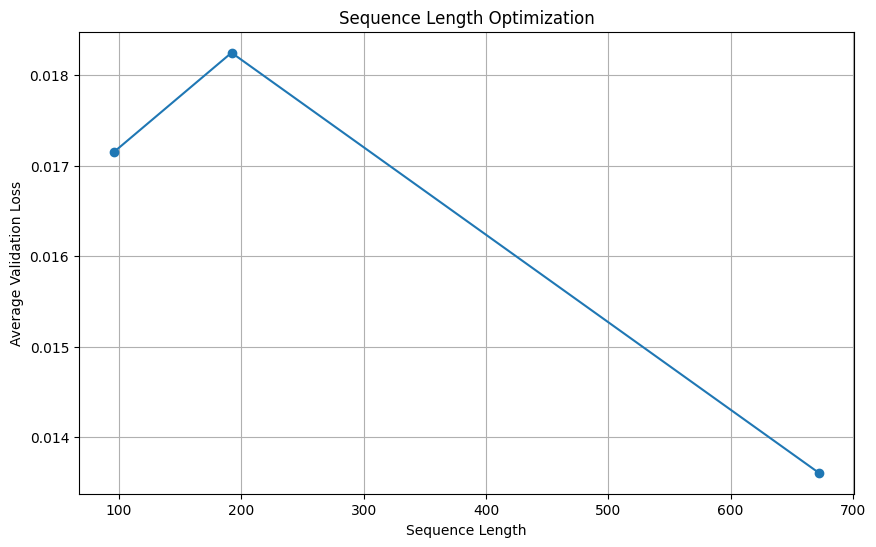

In [63]:
plot_the_loss(seq_lengths, losses)

In [72]:
seq_lengths = [96, 96*2, 96*7]  # Experiment with different sequence lengths for one day, two days, and one week
pred_length = 96  # Predict one day ahead
output_size = 2  # Predicting both total production and consumption

# Step 1: Optimize sequence length
best_seq_length, losses_stack = optimize_seq_length(scaled_train_data, seq_lengths,
                                pred_length, output_size, epochs=5,
                                built_model=build_stacked_lstm_model)

print(f'Best sequence length: {best_seq_length}')

plot_the_loss(seq_lengths, losses_stack)

Epoch 1/5
39/39 - 11s - 287ms/step - loss: 0.1790 - val_loss: 0.0415
Epoch 2/5
39/39 - 4s - 96ms/step - loss: 0.0332 - val_loss: 0.0226
Epoch 3/5
39/39 - 4s - 95ms/step - loss: 0.0246 - val_loss: 0.0245
Epoch 4/5
39/39 - 4s - 97ms/step - loss: 0.0213 - val_loss: 0.0203
Epoch 5/5
39/39 - 4s - 95ms/step - loss: 0.0190 - val_loss: 0.0228
39/39 - 1s - 25ms/step - loss: 0.0228
Sequence Length: 96, Fold Loss: 0.007592915867765744
Epoch 1/5
83/83 - 20s - 236ms/step - loss: 0.1154 - val_loss: 0.0309
Epoch 2/5
83/83 - 13s - 160ms/step - loss: 0.0226 - val_loss: 0.0268
Epoch 3/5
83/83 - 11s - 129ms/step - loss: 0.0177 - val_loss: 0.0239
Epoch 4/5
83/83 - 7s - 83ms/step - loss: 0.0154 - val_loss: 0.0208
Epoch 5/5
83/83 - 10s - 121ms/step - loss: 0.0134 - val_loss: 0.0128
39/39 - 1s - 22ms/step - loss: 0.0128
Sequence Length: 96, Fold Loss: 0.011852419935166836
Epoch 1/5
127/127 - 16s - 125ms/step - loss: 0.0879 - val_loss: 0.0132
Epoch 2/5
127/127 - 10s - 75ms/step - loss: 0.0173 - val_loss: 0.02

In [ ]:
def hypertune_model(save_path, X_train, y_train, X_val, y_val, build_model, max_trials=10,
                    num_fixed_epochs=10):
    # define the hyperparameter search space object
    tuner = BayesianOptimization(build_model, objective='val_loss',
                                max_trials=max_trials, executions_per_trial=1,
                                directory='hypertuning',
                                project_name='energy_prediction')

    tuner.search(X_train, y_train.reshape(y_train.shape[0], -1), epochs=num_fixed_epochs,
                validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

    best_model = tuner.get_best_models(num_models=1)[0]

    # Save the best model
    best_model.save(fr'{save_path}/best_energy_prediction_model.h5')

    # Visualization of hyperparameter tuning
    tuner.results_summary()

    return best_model, tuner

In [ ]:
# static Time Features: Encoded as sine and cosine transformations